# Einführung in die Materialmodellierung - Übung 02 Rheologie
## Installation
 * Wenn sie das Notebook lokal nutzen: Bitte installieren sie Plots über den Package Manager von Julia
     * gehen sie dafür in das REPL (Julia Shell), drücken sie die Taste "]" und tippen sie "add Plots, Plotly"
 * Notebook über Binder oder Jupyterhub hat alles benötigte vorinstalliert

In [8]:
using Plots;

In [9]:
t = collect(0:1:100);

**Nun definieren wir Funktionen, die den vorgegebenen $\varepsilon$ Verlauf erzeugen**

In [10]:
function constant(max::Float64, t::Array)
    load = max * ones(length(t))
    return load
end

function constant_cycle(max::Float64, t::Array)
    T = length(t)
    load = max * ones(T)
    load[(T÷4+1):(T÷2)] .= 0
    load[(T*3÷4+1):T] .= 0
    return load
end

function sinus(max::Float64, t::Array)
    load = max * sin.(8*pi/100*t)
    return load
end;

**Visualisierung der Belastung**

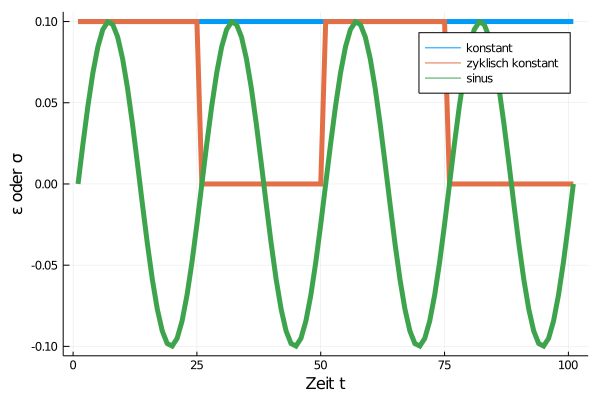

In [11]:
plot(constant(0.1, t), ylabel="ε oder σ", xlabel="Zeit t", label="konstant", line=5)
plot!(constant_cycle(0.1, t), line=5, label="zyklisch konstant")
plot!(sinus(0.1, t), line=5, label="sinus")

## Aufgabe 2.1
**Wenden sie auf die in der Vorlesung hergeleitete Differentialgleichung des Standard Modells das implizite Euler Verfahren an, indem Sie die Zeitableitungen durch**

$$\dot{\sigma}\approx\frac{\sigma_{n+1} - \sigma_n}{\Delta t} \qquad \text{und} \qquad \dot{\varepsilon}\approx \frac{\varepsilon_{n+1} - \varepsilon_n}{\Delta t}$$
**substituieren**

**Zener$_M$ Modell / Standard Modell in Maxwell Repräsentation**

![title](figures/01_ZenerM.png)

$$\frac{\sigma_{n+1} - \sigma_n}{\Delta t} + \frac{E_M}{\eta_M} \sigma_{n+1} = (E_H+E_H)\frac{\varepsilon_{n+1} - \varepsilon_n}{\Delta t}+\frac{E_H E_M}{\eta_M}\varepsilon_{n+1}$$
$$\sigma_{n+1}=\frac{\eta_M\sigma_n + (E_H+E_M)\eta_M(\varepsilon_{n+1} - \varepsilon_n)+E_H E_M\Delta t \varepsilon_{n+1}}{\eta_M + E_M \Delta t}$$
$$\varepsilon_{n+1} = \frac{(E_H + E_M)\eta_M\varepsilon_n+\eta_M(\sigma_{n+1} - \sigma_n) + E_M \Delta t \sigma_{n+1}}{(E_H+E_M)\eta_M+E_H E_M \Delta t}$$

In [13]:
function zenerₘ_σ(Eₘ::Float64, Eₕ::Float64, ηₘ::Float64, ε::Array, t::Array)
    σ = zeros(length(t))
    Δε = zeros(length(t))
    σ[1] = ε[1]*(Eₕ+Eₘ)
    for i in 1:length(t)-1
        Δt = t[i+1] - t[i]
        Δε[i+1] = ε[i+1] - ε[i]
        σ[i+1] = (ηₘ*σ[i] + (Eₕ+Eₘ)*ηₘ*Δε[i+1] + Eₕ*Eₘ*Δt*ε[i+1])/(ηₘ+Eₘ*Δt)
    end
    return σ, Δε;
end

function zenerₘ_ε(Eₘ::Float64, Eₕ::Float64, ηₘ::Float64, σ::Array, t::Array)
    ε = zeros(length(t))
    Δσ = zeros(length(t))
    ε[1] = σ[1]/(Eₕ+Eₘ)
    for i in 1:length(t)-1
        Δt = t[i+1] - t[i]
        Δσ[i+1] = σ[i+1] - σ[i]
        ε[i+1] = ((Eₕ+Eₘ)*ηₘ*ε[i] + ηₘ*Δσ[i+1] + Eₘ*Δt*σ[i+1])/(ηₘ*(Eₕ+Eₘ) + Eₕ*Eₘ*Δt)
    end
    return ε, Δσ
end

zenerₘ_ε (generic function with 1 method)

**Relaxationsversuch**

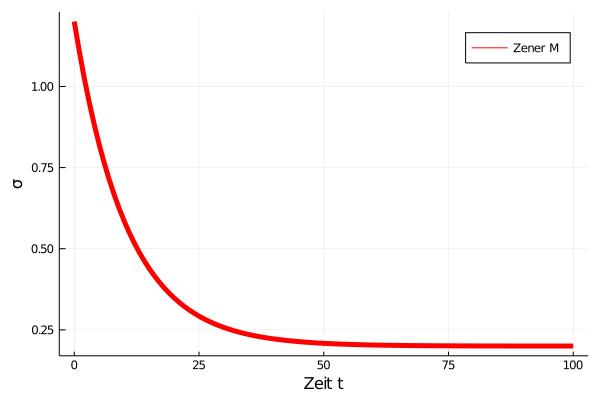

In [18]:
Eₕ = 20.
Eₘ = 100.
ηₘ = 1000.
σ_ZenerM, Δε_ZenerM = zenerₘ_σ(Eₘ, Eₕ, ηₘ, constant(0.01, t), t);
plot(t,σ_ZenerM, ylabel="σ", xlabel="Zeit t", label="Zener M", line=5, color="red")

**Kriechversuch**

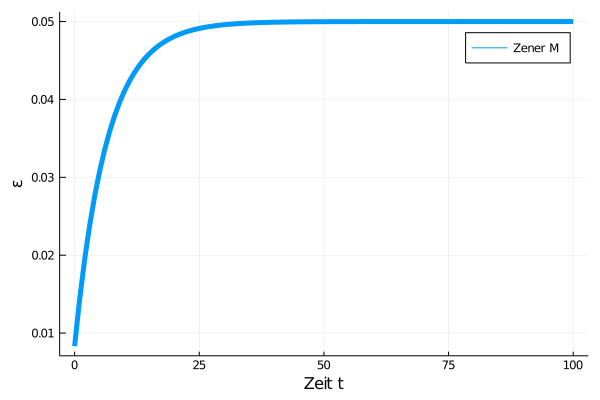

In [15]:
Eₕ = 20.
Eₘ = 100.
ηₘ = 100.
ε_ZenerM, Δε_ZenerM = zenerₘ_ε(Eₘ, Eₕ, ηₘ, constant(1., t), t);
plot(t,ε_ZenerM, ylabel="ε", xlabel="Zeit t", label="Zener M", line=5)

## Aufgabe 2.2

**Implementieren Sie das Modell, welches in der Übung hergeleitet wurde**

$$\frac{E_H+E}{E_H}\frac{\varepsilon_{n+1}-\varepsilon_n}{\Delta t}+\left(\frac{E_K+E}{\eta_K}+\frac{E}{\eta_K}\right)\varepsilon_{n+1} = \frac{1}{E_H} \frac{\sigma_{n+1}-\sigma_n}{\Delta t} + \frac{E_H+E_K}{E_H \eta_K} \sigma_{n+1}$$

In [19]:
function modell_ε(E::Float64, Eₕ::Float64, Eₖ::Float64, ηₖ::Float64, σ::Array, t::Array)
    ε = zeros(length(t))
    Δσ = zeros(length(t))
    ε[1] = σ[1]/(Eₕ+E)
    for i in 1:length(t)-1
        Δt = t[i+1] - t[i]
        Δσ[i+1] = σ[i+1] - σ[i]
        ε[i+1] = (ηₖ*Δσ[i+1] + (Eₕ + Eₖ)*Δt*σ[i+1]+ηₖ*(Eₕ+E)*ε[i])/(ηₖ*(Eₕ+E)+(Eₖ+2*E)*Δt*Eₕ)
    end
    return ε, Δσ
end

modell_ε (generic function with 1 method)

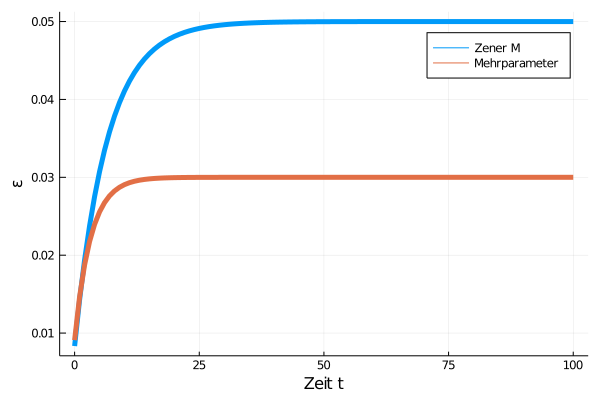

In [20]:
Eₕ = 100.
Eₖ = 20.
E = 10.
ηₖ = 100.
ε_Modell, Δε_Modell = modell_ε(E, Eₕ, Eₖ, ηₖ, constant(1., t), t);
plot(t,ε_ZenerM, ylabel="ε", xlabel="Zeit t", label="Zener M", line=5)
plot!(t, ε_Modell, label ="Mehrparameter", line=5)

**Endbedingung**
$$\varepsilon(\infty)=\frac{E_H+E_K}{E_H\cdot(E_K+2E)}\cdot \tilde{\sigma}$$

In [21]:
ε_∞ = (Eₕ+Eₖ)/(Eₕ*(Eₖ+2*E))*1

0.03